In [55]:
import keras
from keras import backend as K
from keras.layers.core import Dense, Activation
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.models import Model
from keras.applications import imagenet_utils
from keras.layers import Dense,GlobalAveragePooling2D
from keras.applications import MobileNet
from keras.applications.mobilenet import preprocess_input
import numpy as np
from PIL import Image
from keras.optimizers import Adam
import matplotlib.pyplot as plt
from keras.models import load_model

In [56]:
mobile = keras.applications.mobilenet.MobileNet()
def prepare_image(file):
    img_path = ''
    img = image.load_img(img_path + file, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array_expanded_dims = np.expand_dims(img_array, axis=0)
    return keras.applications.mobilenet.preprocess_input(img_array_expanded_dims)
  

base_model=MobileNet(weights='imagenet',include_top=False) #imports the mobilenet model and discards the last 1000 neuron layer.

x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dense(1024,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
x=Dense(1024,activation='relu')(x) #dense layer 2
x=Dense(512,activation='relu')(x) #dense layer 3
preds=Dense(2,activation='softmax')(x) #final layer with softmax activation

model=Model(inputs=base_model.input,outputs=preds)

for layer in model.layers[:20]:
    layer.trainable=False
for layer in model.layers[20:]:
    layer.trainable=True

In [ ]:
train_datagen=ImageDataGenerator(preprocessing_function=preprocess_input)
train_generator=train_datagen.flow_from_directory('/content/drive/MyDrive/google-images-download/images/',
                                                 target_size=(224,224),
                                                 color_mode='rgb',
                                                 batch_size=32,
                                                 class_mode='categorical',
                                                 shuffle=True)

test_generator=train_datagen.flow_from_directory('/content/drive/MyDrive/google-images-download/images_val/',
                                                 target_size=(224,224),
                                                 color_mode='rgb',
                                                 batch_size=16,
                                                 class_mode='categorical',
                                                 shuffle=True)

Found 311 images belonging to 2 classes.
Found 80 images belonging to 2 classes.


In [ ]:
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
model.fit_generator(generator = train_generator,
                  steps_per_epoch=9,validation_data = test_generator,validation_steps = 5,
                  epochs=12)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/12
9/9 [==============================] - 83s 9s/step - loss: 1.0402 - accuracy: 0.6536 - val_loss: 0.5737 - val_accuracy: 0.8250
Epoch 2/12
9/9 [==============================] - 54s 6s/step - loss: 0.1282 - accuracy: 0.9815 - val_loss: 3.5853 - val_accuracy: 0.6500
Epoch 3/12
9/9 [==============================] - 64s 7s/step - loss: 0.2036 - accuracy: 0.9418 - val_loss: 0.3683 - val_accuracy: 0.9000
Epoch 4/12
9/9 [==============================] - 63s 7s/step - loss: 0.0889 - accuracy: 0.9623 - val_loss: 12.1639 - val_accuracy: 0.5000
Epoch 5/12
9/9 [==============================] - 62s 7s/step - loss: 0.0700 - accuracy: 0.9741 - val_loss: 1.8770 - val_accuracy: 0.7500
Epoch 6/12
9/9 [==============================] - 64s 7s/step - loss: 0.0738 - accuracy: 0.9734 - val_loss: 1.2524 - val_accuracy: 0.7625
Epoch 7/12
9/9 [==============================] - 58s 6s/step - loss: 0.0272 - accuracy: 1.0000 - val_loss: 0.5174 - val_accuracy: 0.8875
Epoch 8/12
9/9 [=================

In [66]:
model = load_model('/content/saved_model')

In [67]:
def load_image(img_path, show=False):

    img = image.load_img(img_path, target_size=(416, 416))
    img_tensor = image.img_to_array(img)                   # (height, width, channels)
    img_tensor = np.expand_dims(img_tensor, axis=0)       # (1, height, width, channels), add a dimension because the model expects this shape: (batch_size, height, width, channels)
    img_tensor /= 255.                                      # imshow expects values in the range [0, 1]

    if show:
        plt.imshow(img_tensor[0])                           
        plt.axis('off')
        plt.show()

    return img_tensor

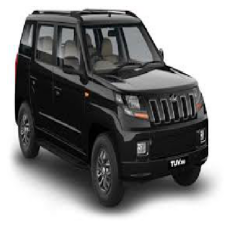

In [68]:
img_path = '/content/drive/MyDrive/google-images-download/tuv.png'
new_image = load_image(img_path,show =True)

In [69]:
pred = model.predict(new_image)
ans = np.argmax(pred, axis=-1)
ans

array([0])

In [ ]:
from numpy.core.fromnumeric import size
import cv2
import numpy as np
import imutils
from imutils.video import FPS
from keras.models import load_model
from  google.colab.patches import cv2_imshow

INPUT = 'demo.MOV'
OUTPUT = 'output.avi'
LABEL = '/content/drive/MyDrive/Research_Topics_AI/object-detection-opencv/yolov3.txt'
CONFIG = '/content/drive/MyDrive/Research_Topics_AI/object-detection-opencv/yolov3.cfg'
WEIGHT  = '/content/drive/MyDrive/Research_Topics_AI/object-detection-opencv/yolov3.weights'

#model = load_model('/content/drive/MyDrive/Research_Topics_AI/object-detection-opencv/saved_model')

vs = cv2.VideoCapture(INPUT)
writer = None
fps = FPS().start()

Width = None
Height = None

writer = cv2.VideoWriter(OUTPUT,cv2.VideoWriter_fourcc(*'MJPG'),25,(800,600),1)

def get_output_layers(net):
    
    layer_names = net.getLayerNames()
    
    layer_names = [layer_names[i[0] - 1] for i in net.getUnconnectedOutLayers()]

    return layer_names


def draw_prediction(img, class_id, confidence, x, y, x_plus_w, y_plus_h):

    label = str(classes[class_id])

    color = COLORS[class_id]

    cv2.rectangle(img, (x,y), (x_plus_w,y_plus_h), color, 2)
    cv2.putText(img, label, (x,y-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
    #pred = model.predict(img)
    #ans = pred.argmax(axis = -1)
    #if ans[0] == 0:
     #   cv2.putText(img, 'sedan', (x,y-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
    #else:
     #   cv2.putText(img, 'suv', (x,y-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
        

classes = None

with open(LABEL, 'r') as f:
    classes = [line.strip() for line in f.readlines()]

COLORS = np.random.uniform(0, 255, size=(len(classes), 3))

net = cv2.dnn.readNet(CONFIG,WEIGHT)
  




while True:
    try:
        (grabbed,frame) = vs.read()#
    except:
        break

    if not grabbed:
        break
    blob = cv2.dnn.blobFromImage(frame, 1/255.0, (416,416), (0,0,0), True, crop=False)
    net.setInput(blob)

    if Width is None or Height is None:
        Height,Width = frame.shape[:2]
    outs = net.forward(get_output_layers(net))


    class_ids = []
    confidences = []
    boxes = []
    conf_threshold = 0.5
    nms_threshold = 0.4


    for out in outs:
        for detection in out:

            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]

            if confidence > 0.5:
                box = detection[0:4] * np.array([Width,Height,Width,Height])
                (center_x,center_y,w,h) = box.astype("int")

                x = center_x - w / 2
                y = center_y - h / 2

                class_ids.append(class_id)
                confidences.append(float(confidence))
                boxes.append([x, y, int(w), int(h)])


    indices = cv2.dnn.NMSBoxes(boxes, confidences, conf_threshold, nms_threshold)

    for i in indices:
        i = i[0]
        box = boxes[i]
        x = box[0]
        y = box[1]
        w = box[2]
        h = box[3]        

        draw_prediction(frame, class_ids[i], confidences[i], round(x), round(y), round(x+w), round(y+h))

    cv2_imshow(cv2.resize(frame,(800,600)))
    fps.update()
    writer.write(cv2.resize(frame,(800,600)))
    if cv2.waitKey(1) & 0xFF == ord('s'): 
        break
fps.stop()

cv2.destroyAllWindows()
writer.release()
vs.release()